Homework 4 - João Guilherme Santos Lazzaro

## Question 1

The problem is:
$$\max_{\{c_t,k_t\}_{t=0}^\infty} \sum_{t=0}^\infty \beta^t \log(c_t)$$
s.t.
$$ c_t+k_{t+1} = A k_t^\theta +(1-\delta)k_t$$
The FOCs imply that:
$$ \frac{c_{t+1}}{c_t} = \beta (A\theta k_{t+1}^{\theta-1} + 1-\delta)$$
Hence, $$k_{ss} = \left(\frac{1-\beta(1-\delta)}{\beta A \theta}\right)^{\frac{1}{\theta-1}} $$



The functional equation is:
$$F(c)(k) =  1-\beta \frac{c(k)}{c(Ak^\theta +(1-\delta)k-c(k))}(A\theta (A\theta k^\alpha + (1-\delta)k - c(k))^{\theta-1} + 1-\delta)  = 0$$

And, in the test case $\delta = 1$, we know the closed form solution:
$$c(k) = (1-\beta \theta) A k^{\theta} $$ 



Let us now define some parameters and find the Steady State value of capital:

In [2]:
using Plots, Optim, LinearAlgebra, FastGaussQuadrature

#Defining parameters
θ = 0.25
β = 0.9
δ = 1
A = (1-β*(1-δ))/(θ * β) #This will normalize the SS to 1
kss = ((1- β*(1-δ))/(β*A*θ))^(1/(θ-1))

┌ Info: Recompiling stale cache file C:\Users\jgsla\.julia\compiled\v1.0\FastGaussQuadrature\vg51R.ji for FastGaussQuadrature [442a2c76-b920-505d-bb47-c5924d526838]
└ @ Base loading.jl:1184


1.0

We will use the finite element method with the piecewise linear base function $\varphi_i$ defined below (and in the lecture notes):


In [3]:
#Finite elements Piecewise Linear function:
function ϕi(x,X,i::Int)
    #x: point to evaluate the function
    #X: Vector with elements nodes
    #i: Which element in the function
    if i>1 && i<length(X) #i is not in a boundary
        if X[i-1]<=x<=X[i]
            f = (x-X[i-1])/(X[i]-X[i-1])
        elseif X[i]<=x<=X[i+1]
            f = (X[i+1]-x)/(X[i+1]-X[i])
        else
            f = 0
        end
    elseif i==1 #i is in the boundary(1)
        if X[i]<=x<=X[i+1]
            f = (X[i+1]-x)/(X[i+1]-X[i])
        else
            f = 0
        end
    elseif i==length(X) #i is in the top boundary
        if X[i-1]<=x<=X[i]
            f = (x-X[i-1])/(X[i]-X[i-1])
        else
            f=0
        end
    end
    return f
end


ϕi (generic function with 1 method)

The elements node $k_i\in[0,2]$ with their distance increasing exponentially since it is known that the consuption function is less linear close to 0. We have 15 nodes.

In [4]:
#Defining the elements:
#In this case, we are putting more elements at low values of k because the function is known to be "less linear" in that region.
K = zeros(15)
for i=2:length(K)
    global K
    K[i] = K[i-1] +0.0005*exp(0.574*(i-2))
end
K

15-element Array{Float64,1}:
 0.0                  
 0.0005               
 0.0013876771423281366
 0.0029636185603518304
 0.0057614729092074785
 0.010728655615292541 
 0.019547164715211198 
 0.03520314263003213  
 0.06299805010159346  
 0.11234385817285451  
 0.19995014996199395  
 0.35548235545269025  
 0.6316071228726379   
 1.1218264118113592   
 1.9921393268498697   

We will approximate the consumption functio $c(k)$ by:
$$ c^n(k;\alpha) = \sum_{i=1}^n\alpha_i\varphi_i(k)$$

In [5]:
function cn(k,α;K=K)
#This function is piecewise linear approximation for a function with arguments k
#To get a good approximations one need to find the parameters α
#K are the elements nodes. It is optionally defined here for efficiency. 
        n = length(K)
        c = 0
        for i = 1:n
            c = c + α[i]*ϕi(k,K,i)
        end
        return c
end

cn (generic function with 1 method)

The Residual equation is:

$$R(k;\alpha) = F(c^n(k;\alpha))$$
$$ =  1-\beta \frac{\sum_{i=1}^n\alpha_i\varphi_i(k)}{\sum_{i=1}^n\alpha_i\varphi_i(Ak^\theta +(1-\delta)k-\sum_{i=1}^n\alpha_i\varphi_i(k))}(A\theta (A\theta k^\alpha + (1-\delta)k - \sum_{i=1}^n\alpha_i\varphi_i(k))^{\theta-1} + 1-\delta)  = 0$$

In [6]:
#capital policy function from Bugdet constraint
polk(k,α) = min(max(eps(),A*k.^θ+(1-δ)*k-cn(k,α)),K[end])
#min max are needed to avoid NaNs and other numerical instabilities

function residual(k,α)
    #This function is specific for the deterministic growth model.
    #Residual function comes from FOCs
    #cn below is an approximation for consumption
        R = cn(k,α)/cn(polk(k,α),α) * β * (A*θ*polk(k,α)^(θ-1)+1-δ)- 1
    return R
end

residual (generic function with 1 method)

Since the finite element method is a Galerkin method, the base function is the weight we use to minimize the weighted residual:
$$ \min_\alpha \int_0^\bar{k} \varphi_i(k) R(k;\alpha) dk $$
To calculate the integral, we use Gauss-Legendre method with 3 nodes per element. Also note, that we impose the boundary condition $\alpha_1 = 0$ since this imply $c(0) = 0$.

In [7]:
function integra(k,α;K=K)
#This function calculates the function that will be integrated:
#integra(k;α):= ϕi(k)R(k;α), where ϕi are the weights and R is the residual function
#In the Finite element methods, the weights are the same as the approximating functions
    T=zeros(length(K))
    for i=1:length(K)
        T[i] = ϕi(k,K,i)*residual(k,α)
    end
    return T
end

#This function calculates the integral (the norm of the integrated functions), as a functions of the parameters to minimized
#We define that way since this is the format accepted by the solver:
#mini(α):= ∫integra(k;α)dk
nodes, weights = gausslegendre(3*(length(K)-1)) #Gauss Legendre nodes and weights,this function is just a Quadrature table
function mini(α;nodes=nodes,weights=weights,K=K)
    if length(α)<length(K)
        α = vcat(0,α)
    end
    #g = quadgk.(integra,K[1],K[end])[1] #Integral
    #See Judd's book pg 261 on numerical integration and the gausslegendre formula:
    gaussleg = zeros(length(K))
    for j=1:length(nodes)
        gaussleg .+= (K[end]-K[1])/2 .* weights[j] .* integra((nodes[j] .+1).*
        (K[end]-K[1])/2 .+ K[1],α)
    end
    return norm(gaussleg,1)
end

mini (generic function with 1 method)

Let's start the minimization procedure. We use the BFGS method which is a Quasi-Newton method. It does not calculates the Hessian as a Newton procedure would do, but it approximates the Hessian by a positive definite approximation which is easier to compute and invert (see Judd's book). Note that this minimization step is extremely sensitive to initial conditions. A grid search or another procedure might be needed to determine the initial parameters.

In [8]:
#Setting initial conditions
initial =  ones(length(K)-1) .* range(0.35, stop = 3.5, length = length(K)-1)

#Check if the initial conditions are somewhat close to the true parameters. 
mini(initial)


0.6613235916442249

In [9]:
#Here we start the minimization procedure we want to find α:= argmin mini(α)

#Solver stuff
#lower and upper bound of the parameters:
lower = zeros(length(initial))
upper = Inf*ones(length(initial))
#Optimizer method is BFGS, see Judd's book page 114 for an explanation:
inner_optimizer = BFGS()

#Solver:
bla = optimize(mini,lower,upper,initial, Fminbox(inner_optimizer))
#Parameters
α = vcat(0,bla.minimizer) #we need to concatenate to include the boundary condition

15-element Array{Float64,1}:
 0.0                
 0.37442113219372514
 0.6640748582488243 
 0.8539733791826457 
 0.9252970761844344 
 1.1458792909060764 
 1.29154740222145   
 1.4961818748748827 
 1.730224876203169  
 2.0077754086540636 
 2.3141705183580985 
 2.6711610637841803 
 3.085257330000326  
 3.565426495237902  
 4.116321573422392  

In [10]:
#Checking if the residual is low at the solution
mini(α)

8.706464890141266e-6

Below, we plot the approximate consumption function and the true one. As we can see, the approximation is barely indistinguible from the true function.

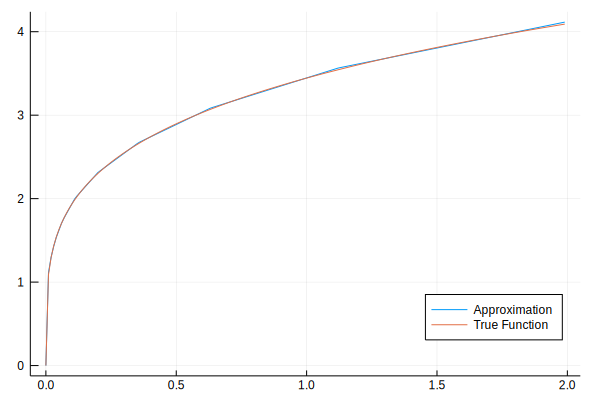

In [11]:
#Plotting
k=K[1]:0.01:K[end]

c(k) = (1-β*θ)*A*k^θ
polkplot(k) = polk(k,α)
cnplot(k) = cn(k,α)
plot(k,[cnplot.(k),c.(k)],label=["Approximation" "True Function"],legend=:bottomright)

Now, we do the same procedure for a case with $\delta =0.05$. Note that now we can't compare to a known formula, but the shape should be similar to the one above.

In [12]:
#New parameters
δ = 0.05
A = (1-β*(1-δ))/(θ * β) #This will normalize the SS to 1

kss = ((1- β*(1-δ))/(β*A*θ))^(1/(θ-1))

polk(k,α) = min(max(eps(),A*k.^θ+(1-δ)*k-cn(k,α)),K[end]) #capital policy function from Bugdet constraint

function residual(k,α) #Residual function comes from FOCs
        R = β * cn(k,α)/cn(polk(k,α),α)  * (A*θ*polk(k,α)^(θ-1)+1-δ)- 1
    return R
end

residual (generic function with 1 method)

In [13]:
initial = ones(length(K)-1)*0.0035
for i=2:length(initial)
    global initial
    initial[i] = initial[i-1] +0.000265*exp(0.589*(i-2))
end
initial
#initial = ones(length(K)-1)*0.1.*range(0.03,stop = 8,length = length(K)-1)
mini(initial)

0.560172602119699

In [14]:
#Solver stuff
#lower and upper bound of the parameters:
lower = zeros(length(initial))
upper = Inf*ones(length(initial))
#Optimizer method is BFGS, see Judd's book page 114 for an explanation:
inner_optimizer = BFGS()

#Solver:
bla = optimize(mini,lower,upper,initial, Fminbox(inner_optimizer))
#Parameters
α = vcat(0,bla.minimizer)

15-element Array{Float64,1}:
 0.0                 
 0.01239167265675882 
 0.09230419026395284 
 0.021151728251957085
 0.115504132550029   
 0.12844822914611462 
 0.15135403379323256 
 0.17588563782962213 
 0.20737801051704224 
 0.24777147103586775 
 0.3013961059132636  
 0.3754319853414289  
 0.4808309867565117  
 0.6344669728788809  
 0.852052586048369   

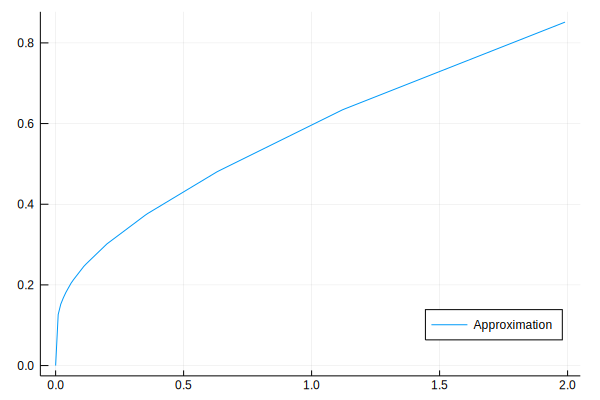

In [15]:
#Plotting
k=K[1]:0.01:K[end]

cn2plot(k) = cn(k,α)
plot(k,[cn2plot.(k)],label=["Approximation"],legend=:bottomright)

This seems a fair approximation to the consumption function.

## Question 2

The Problem is:
$$ \max \int_0^\infty  e^{-\rho t} \log(c)\, dt$$

s.t.
$$dk = (Ak^\theta -\delta k ) dt -c$$

The Bellman's equation for this problem is:
$$ \rho V(k) = \max \log(c) + V'(k)(Ak^\theta - \delta k) -c) $$

The maximization problem FOC is:
$$\frac{1}{c} = V'(k) $$

By the envelope theorem:
$$\rho V'(k) = V'(k)(\theta A k^{\theta - 1} - \delta) + V''(k)(Ak^\theta-\delta k - c) $$ 

From the FOC:
$$ V''(k) = -\frac{1}{c(k)^2} c'(k)$$

Combining the expressions above, we get the differential equation:
  $$c(k)(\theta A k^{\theta-1}-(\delta +\rho) = (Ak^\theta - \delta k -c(k)) c'(k) $$

We also have in the Steady State:
$$k_{ss} = \left(\frac{\delta+\rho}{\theta A}\right)^{\frac{1}{\theta-1}} $$
$$c_{ss} = Ak_{ss}^\theta - \delta k_{ss} $$


I don't really see how having $\delta = 1$ would help me having a test case. Candler's chapter in Marimon & Scott book claims that we do not have closed form solutions for arbitrary parameters, but we do have when utility is CRRA with parameter 0.5, which is not our case here. So, unfortunately I will not have a comparison.

The functional equation is thus:
 $$F(c)(k) = c(k)(\theta A k^{\theta-1}-(\delta +\rho) - (Ak^\theta - \delta k -c(k)) c'(k) = 0 $$

Let's define some parameters:

In [16]:
#Defining parameters
θ = 0.25
ρ = -log(0.9)
δ = 1
A = (δ + ρ)/θ  #This will normalize the SS to 1
kss = ((δ+ρ)/(A*θ))^(1/(θ-1))

1.0

We'll use the finite element methods, so all functions defined above are useful. We need only first to define the derivative of the piecewise linear function:

In [17]:
function derivϕi(x,X,i)
    if i>1 && i<length(X) #i is not in a boundary
        if X[i-1]<=x<=X[i]
            f = 1/(X[i]-X[i-1])
        elseif X[i]<=x<=X[i+1]
            f = -1/(X[i+1]-X[i])
        else
            f = 0
        end
    elseif i==1
        if X[i]<=x<=X[i+1]
            f = -1/(X[i+1]-X[i])
        else
            f = 0
        end
    elseif i==length(X)
        if X[i-1]<=x<=X[i]
            f = 1/(X[i]-X[i-1])
        else
            f=0
        end
    end
    return f
end

derivϕi (generic function with 1 method)

In [18]:
#Defining the elements:
K = zeros(15)
for i=2:length(K)
    global K
    K[i] = K[i-1] +0.0005*exp(0.574*(i-2))
end
K

15-element Array{Float64,1}:
 0.0                  
 0.0005               
 0.0013876771423281366
 0.0029636185603518304
 0.0057614729092074785
 0.010728655615292541 
 0.019547164715211198 
 0.03520314263003213  
 0.06299805010159346  
 0.11234385817285451  
 0.19995014996199395  
 0.35548235545269025  
 0.6316071228726379   
 1.1218264118113592   
 1.9921393268498697   

In this way, we can define the derivative of the consumption function:


In [19]:
function derivcn(k,α;K=K)
#This function is piecewise linear approximation for the derivative of a function with arguments k
#To get a good approximations one need to find the parameters α
#K are the elements nodes. It is optionally defined here for efficiency. 
        n = length(K)
        c = 0
        for i = 1:n
            c = c + α[i]*derivϕi(k,K,i)
        end
        return c
end

derivcn (generic function with 1 method)

Naturally, we'll need to redefine the residual function:

In [20]:
include("finite_elements_functions.jl")
#Defining the residual function from Euler equation:
function residual(k,α)
    #This function is specific for the deterministic growth model.
    #Residual function comes from FOCs
    #cn is an approximation for consumption
    #derivcn is an approxiamtion for the derivative of consumption.
        R = θ*A*k^(θ-1)-(δ+ρ) - derivcn(k,α)/cn(k,α) * (A*k^θ-δ*k-cn(k,α))
    return R
end

residual (generic function with 1 method)

We can proceed with the maximization process as before:

In [21]:
#Setting initial conditions

initial = ones(length(K)-1)*0.05
for i=2:length(initial)
    global initial
    initial[i] = initial[i-1] +0.165*exp(0.08*(i-2))
end
initial
#Check if the initial conditions are somewhat close to the true parameters.
#mini(initial)

14-element Array{Float64,1}:
 0.05               
 0.21500000000000002
 0.3937423661663682 
 0.5873716598800169 
 0.7971277696830488 
 1.0243538507984817 
 1.2705049259092913 
 1.5371572022711186 
 1.8260181648199754 
 2.1389375099052925 
 2.477918989661534  
 2.845133242862791  
 3.2429316944216304 
 3.6738616125364447 

In [53]:
#Solver stuff:
    #lower and upper bound of the parameters:
    lower = zeros(length(initial))
    upper = Inf*ones(length(initial))
    #Optimizer method is BFGS, see Judd's book page 114 for an explanation:
    inner_optimizer = BFGS()


#Solver:
bla = optimize(mini,lower,upper,initial, Fminbox(inner_optimizer))
#Parameters
αcont = vcat(0,bla.minimizer)

15-element Array{Float64,1}:
 0.0                
 0.19396272687684454
 0.42643297440642164
 0.659358606555276  
 0.5615689980755327 
 0.7529694430997189 
 0.6153895256123474 
 0.7995275668295624 
 1.0422042487340248 
 1.1889787934266627 
 1.617465258477728  
 2.0926639905250934 
 2.7250222831048774 
 3.6847649563027844 
 4.906164184156026  

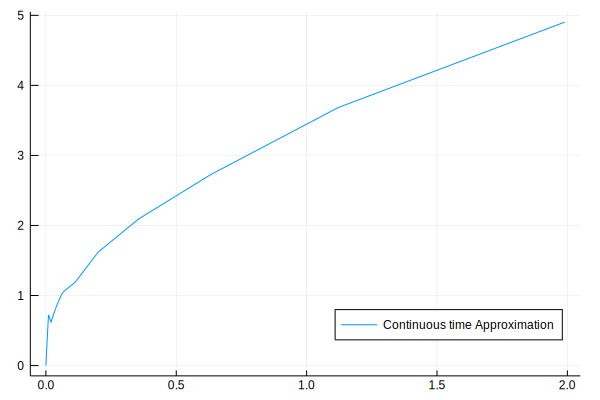

In [54]:

#Plotting
k=K[1]:0.01:K[end]

#c(k) = (1-β*θ)*A*k^θ
contplot(k) = cn(k,αcont)

plot(k,[contplot.(k)],label=["Continuous time Approximation"],legend=:bottomright)

This looks like a good consumption function!


## Question 3

It has been a while since the last time I opened the HW 1 codes. Sometimes a person should not revolve his past, but let's do it!

In [69]:
#Get the VFI objects, see HW1 or the file "run_VFI.jl" to adjust parameters.
include("HW1_stuff\\run_VFI.jl")

([-75.1926; 10.9757; … ; 12.5878; 12.5899], [1; 26; … ; 90; 90], [150; 150; … ; 150; 150], [0.000542535; 1.17705; … ; 4.08135; 4.09023], 2.220446049250313e-16:0.013370062596307849:1.9921393268498697, 0.0:0.006711409395973154:1.0, 7.307295035053245, 1)

Below, I plot the consumption policy functions for the discrete and continuous time case above and compare them with the VFI policy function I found when doing HW1.

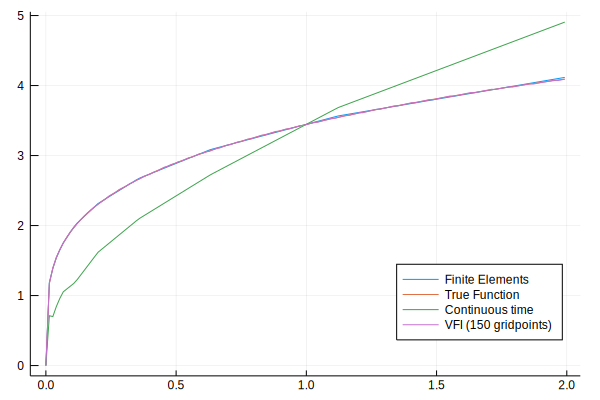

In [70]:
#Plotting the consumption policies
plot(k,[cnplot.(k),c.(k),contplot.(k),policy_c],label=["Finite Elements" "True Function" "Continuous time" "VFI (150 gridpoints)"],legend=:bottomright)

As we can see above, all the methods produce good results when compared to the true function (I'm using $\delta = 1$). I'm not sure if the continuous time case is comparable, since the model is using different assumptions and not only a different solution method. The problem with the VFI method is that I used gridpoints andthe function cannot be evaluated at points outside the grid.

## Question 4

Below a plot of the consumption time series generated by each model starting at $0.5k_{ss}$, given the problems found above, I don't plot the continuous time. As we can se, there very small are differences in the time series when compared to the true function.

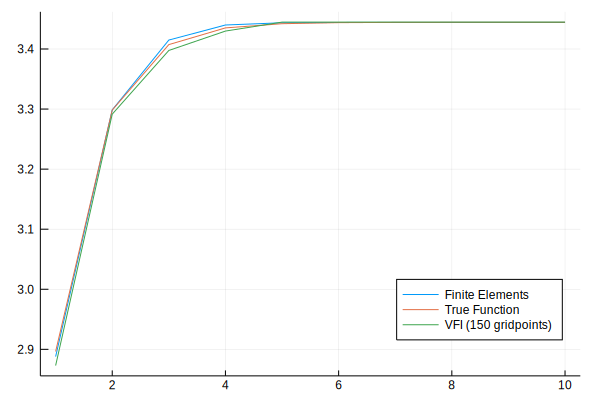

In [71]:
k_finiteelements=0.5*ones(10)
k_VFI_index = Int(floor(KVFI/4))*ones(Int,10)
true_k =  0.5*ones(10)

for i=2:10
    global k_finiteelements, k_VFI_index
    k_finiteelements[i] = polkplot(k_finiteelements[i-1])
    k_VFI_index[i] = policy_k[k_VFI_index[i-1]]
    true_k[i] = β*θ*A*true_k[i-1]^θ
end
c_VFI = policy_c[k_VFI_index]
c_finiteelements = cnplot.(k_finiteelements)
true_c = c.(true_k)


plot(1:10,[c_finiteelements,true_c,c_VFI],label=["Finite Elements" "True Function" "VFI (150 gridpoints)"],legend=:bottomright)
